# [GDCV]2nd_Project-Augmentation
********************
## 1. 데이터 불러오기
## 2. Augment 설정
## 3. 모델 설계 및 학습
## 4. 결과 비교 및 분석
******************

## 1. 데이터 불러오기

      이번 과정에선 stanford_dogs 데이터셋을 사용합니다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

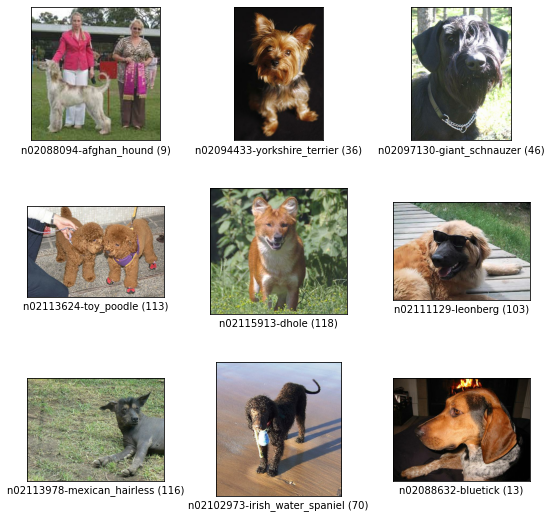

In [3]:
import urllib3

urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

fig = tfds.show_examples(ds_train, ds_info)

## 2. Augment 설정

      먼저 정규화와 리사이즈 함수를 설정합니다. 리사이즈 크기는 (224, 224, 3)으로 합니다.

In [4]:
def normalize_and_resize_img(image, label):
    #Normalizes images: `uint8` -> `float32`.#
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

      사용하는 Augment 함수로는 가장 먼저 좌우반전과 밝기 조절을 적용한 함수를 만들어줍니다,

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

      두 번째로는 CutMix함수를 사용합니다. 노드에서 제공된 함수는 이미지에 상관없이 전부 사용할 수 있는 함수였지만 오류로 인해 수정이 필요합니다. 

In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
# mix two images

def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

      세 번째로는 Mixup함수를 사용합니다. 두 이미지를 랜덤한 비율로 합성해줍니다.

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

      마지막으로 onehot함수로 라벨값들을 스칼라에서 벡터로 바꿔줍니다.

In [12]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

      위에서 작성한 Augment함수들을 적용하는 전체 함수를 작성해줍니다.

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 3. 모델 설계 및 학습
        
      각각 No Augment, Augment, Augment+CutMix, Augment+Mixup 모델을 만들어줍니다.

In [14]:
num_classes = ds_info.features["label"].num_classes

In [15]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [17]:
cut_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

      각각의 모델에 사용할 훈련 데이터를 위에서 만든 함수를 사용하여 따로 만들어줍니다.

In [19]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

     각 모델당 20Epoch씩 학습을 수행합니다.

In [20]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cut_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [21]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 56s - loss: 5.2938 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0596s vs `on_train_batch_end` time: 0.0898s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2154 - accuracy: 0.4429WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0078s vs `on_test_batch_end` time: 0.0290s). Check your callbacks.


750/750 [==============================] - 112s 149ms/step - loss: 2.2154 - accuracy: 0.4429 - val_loss: 3.1658 - val_accuracy: 0.2382
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 0.7959 - accuracy: 0.7724 - val_loss: 1.1498 - val_accuracy: 0.6622
Epoch 3/20
750/750 [==============================] - 112s 150ms/step - loss: 0.3273 - accuracy: 0.9201 - val_loss: 1.0853 - val_accuracy: 0.6912
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 0.1245 - accuracy: 0.9810 - val_loss: 0.9585 - val_accuracy: 0.7263
Epoch 5/20
750/750 [==============================] - 113s 150ms/step - loss: 0.0547 - accuracy: 0.9952 - val_loss: 0.9278 - val_accuracy: 0.7389
Epoch 6/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0287 - accuracy: 0.9977 - val_loss: 0.9735 - val_accuracy: 0.7315
Epoch 7/20
750/750 [==============================] - 117s 156ms/step - loss: 0.0200 - accuracy: 0.9986 - val_loss: 0.9620 - val_accura

In [22]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:21 - loss: 5.3079 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0491s vs `on_train_batch_end` time: 0.0787s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2520 - accuracy: 0.4295WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0077s vs `on_test_batch_end` time: 0.0298s). Check your callbacks.


750/750 [==============================] - 113s 151ms/step - loss: 2.2520 - accuracy: 0.4295 - val_loss: 2.9545 - val_accuracy: 0.2660
Epoch 2/20
750/750 [==============================] - 113s 150ms/step - loss: 0.9370 - accuracy: 0.7275 - val_loss: 1.1207 - val_accuracy: 0.6698
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 0.5389 - accuracy: 0.8487 - val_loss: 1.1952 - val_accuracy: 0.6599
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 0.2636 - accuracy: 0.9355 - val_loss: 1.0654 - val_accuracy: 0.6948
Epoch 5/20
750/750 [==============================] - 113s 150ms/step - loss: 0.1816 - accuracy: 0.9592 - val_loss: 1.0422 - val_accuracy: 0.7120
Epoch 6/20
750/750 [==============================] - 113s 150ms/step - loss: 0.1260 - accuracy: 0.9728 - val_loss: 1.0124 - val_accuracy: 0.7283
Epoch 7/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0569 - accuracy: 0.9918 - val_loss: 0.9532 - val_accura

In [23]:
history_resnet50_cut = cut_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:25 - loss: 5.0748 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0523s vs `on_train_batch_end` time: 0.0885s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8297 - accuracy: 0.2143WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_test_batch_end` time: 0.0292s). Check your callbacks.


750/750 [==============================] - 114s 153ms/step - loss: 3.8297 - accuracy: 0.2143 - val_loss: 3.4518 - val_accuracy: 0.1974
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 2.9842 - accuracy: 0.4183 - val_loss: 1.4426 - val_accuracy: 0.5926
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 2.7181 - accuracy: 0.4960 - val_loss: 1.3576 - val_accuracy: 0.6206
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 2.5530 - accuracy: 0.5454 - val_loss: 1.3019 - val_accuracy: 0.6343
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.4068 - accuracy: 0.5927 - val_loss: 1.2368 - val_accuracy: 0.6546
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 2.3225 - accuracy: 0.6191 - val_loss: 1.2399 - val_accuracy: 0.6580
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2134 - accuracy: 0.6544 - val_loss: 1.3121 - val_accura

In [24]:
history_resnet50_mix = mix_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:26 - loss: 5.3084 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0528s vs `on_train_batch_end` time: 0.0894s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7564 - accuracy: 0.2327WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0071s vs `on_test_batch_end` time: 0.0304s). Check your callbacks.


750/750 [==============================] - 115s 153ms/step - loss: 3.7564 - accuracy: 0.2327 - val_loss: 4.2856 - val_accuracy: 0.1026
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 2.9271 - accuracy: 0.4632 - val_loss: 1.4899 - val_accuracy: 0.5988
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 2.6788 - accuracy: 0.5408 - val_loss: 1.4220 - val_accuracy: 0.6123
Epoch 4/20
750/750 [==============================] - 116s 155ms/step - loss: 2.5167 - accuracy: 0.6087 - val_loss: 1.4852 - val_accuracy: 0.5946
Epoch 5/20
750/750 [==============================] - 114s 153ms/step - loss: 2.3748 - accuracy: 0.6586 - val_loss: 1.3686 - val_accuracy: 0.6260
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2702 - accuracy: 0.6971 - val_loss: 1.2528 - val_accuracy: 0.6564
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2238 - accuracy: 0.7088 - val_loss: 1.3713 - val_accura

## 4. 결과 비교 및 분석

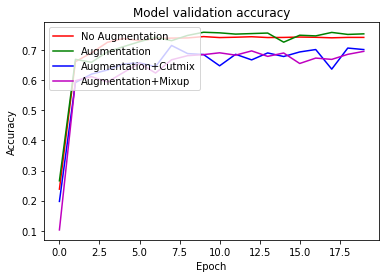

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cut.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mix.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Augmentation+Cutmix', 'Augmentation+Mixup'], loc='upper left')
plt.show()

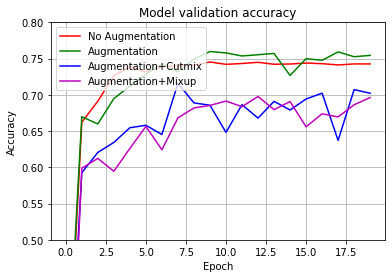

In [26]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cut.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mix.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Augmentation+Cutmix', 'Augmentation+Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

      결과를 보면 Augment를 사용한 것이 가장 정확도가 높았고, 두 번째로는 아무것도 하지 않은 것이 거의 첫번째와 정확도가 유사하였다, 그러나 Augment와 CutMix, Mixup을 같이 사용한 두 모델들은 전부 성능이 약 70%로 비슷하게 낮았다.
      
      이는 이미지를 잘라내거나 합성하는 등 변화가 극심한 Augment를 사용했기 때문에 오히려 성능이 떨어지는 것이라고 생각한다,

*****************************
# 총평 및 결론

      Augment와 No Augment의 차이는 적긴 하나 Augment를 사용한 경우 성능이 향상되었다. 그러나 CutMix나 Mixup을 사용할 경우 오히려 성능이 저하되었는데 이는 왜곡이 심한 학습 데이터가 포함되어 그런것이라고 생각한다,
      
      전에 진행했던 프로젝트 중 가위바위보 예측 모델도 데이터셋에서 다양한 문제가 있는 이미지를 무차별적으로 사용하여 학습을 진행한 적이 있는데 이 경우도 이처럼 학습에 별로 도움이 되지 않는 Augment 인것같다.
      
      너무 과한 것은 좋지 않다는 교훈을 얻었다.